# Simulation 3: Additive mixture, multivariate normal

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn.model_selection import cross_val_score
from scipy.linalg import toeplitz

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

## Random Feature

In [2]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

Generate the predictor

In [3]:
n=500
p=10

np.random.seed(0)
mean = np.zeros(p)
cov=toeplitz(np.logspace(0,p-1, num=p, base=0.5))
data = np.random.multivariate_normal(mean, cov, n) #n points
data.shape

#  sin-ratio function
def sinratio(x,c):
    return (np.sin(c[0]*x))/(2-np.sin(c[1]*x))
#  trigonometric function
def trigonometric(x,u):
    return u[0]*np.sin(x)+u[1]*np.cos(x)+u[2]*np.sin(x)**2


np.random.seed(0)
c=np.random.uniform(1,2,(int(p/2),2))

y=np.zeros(n)
for i in range(n):
    for j in range(int(p/2)):
        y[i]=y[i]+sinratio(data[i][j],c[j])

np.random.seed(0)
u=np.random.uniform(1,2,(int(p/2),3))

for i in range(n):
    for j in range(int(p/2)):
        y[i]=y[i]+trigonometric(data[i][j+int(p/2)],u[j])


        
np.random.seed(0)
test_x = np.random.multivariate_normal(mean, cov, 2*n) #n points
test_y=np.zeros(2*n)
for i in range(n):
    for j in range(int(p/2)):
        test_y[i]=test_y[i]+sinratio(test_x[i][j],c[j])
for i in range(2*n):
    for j in range(int(p/2)):
        test_y[i]=test_y[i]+trigonometric(test_x[i][j+int(p/2)],u[j])

y.shape,data.shape,test_x.shape,test_y.shape

((500,), (500, 10), (1000, 10), (1000,))

In [4]:
train_x=data
train_y=y
nntrain_x = torch.from_numpy(train_x).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len


## 1. DNN

In [5]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(p, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(1000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    x0=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        test_pred = net(x0)
    
    dnn_trainloss.append(mean_squared_error(pred,train_y))
    dnn_testloss.append(mean_squared_error(test_pred,test_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {dnn_trainloss[-1]}
            Test set - loss: {dnn_testloss[-1]}
            ''')
    
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=8, bias=True)
  (fc5): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 84.33557261103782
            Test set - loss: 75.8937477028106
            
epoch 100
            Train set - loss: 0.473321962083236
            Test set - loss: 2.379844680582661
            
epoch 200
            Train set - loss: 0.19236686546327883
            Test set - loss: 2.183165044555639
            
epoch 300
            Train set - loss: 0.10072656328559333
            Test set - loss: 2.3552842884883147
            
epoch 400
            Train set - loss: 0.07389263022078153
            Test set - loss: 2.3472586898092103
            
epoch 500
            Train set - loss: 0.05890376448354605
            Test set - loss: 2.3060259328

## 2. Resnet

In [6]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(p,64)
        self.rblock2 = ResidualBlock(64,32)
        self.rblock3 = ResidualBlock(32,16)
        self.rblock4 = ResidualBlock(16,8)
        self.fc5 = nn.Linear(8,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        x = self.rblock3(x)
        x = self.rblock4(x)
        return self.fc5(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(1000):
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        
    x0=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        test_pred = net(x0)
    
    res_trainloss.append(mean_squared_error(pred,train_y))
    res_testloss.append(mean_squared_error(test_pred,test_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {res_trainloss[-1]}
            Test set - loss: {res_testloss[-1]}
            ''')
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 17.419836094659537
            Test set - loss: 17.135917835797024
            
epoch 100
            Train set - loss: 0.1980866599817884
            Test set - loss: 2.3672511000015586
            
epoch 200
            Train set - loss: 0.06739788313257927
            Test set - loss: 2.089401636547643
            
epoch 300
            Train set - loss: 0.03548536568001454
            Test set - loss: 2.0825653960370576
            
epoch 400
            Train set - loss: 0.02399829527431764
            Test set - loss: 2.0623425490131004
            
epoch 500
            Train set - loss: 0.016531094636070626
            Test set - loss: 1.9992215696244107
            
epoch 600
            Train set - loss: 0.010372892056967092
            Test set - loss: 1.9739224883855442
            
epoch 700
            Train set - loss: 0.0046872334569807335
            Test set - loss: 1.9269666046367806
            
epoch 800
            Train set -

# 3. MLKM

In [7]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

rff1=RandomFourierFeature(p,64,kernel='G',gamma=0.25)
rff2=RandomFourierFeature(32,32,kernel='G',gamma=0.5)
rff3=RandomFourierFeature(16,16,kernel='G',gamma=1)
rff4=RandomFourierFeature(8,8,kernel='G',gamma=2)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        x=self.fc2(x)
        x = rff3.transform(x)
        x=self.fc3(x)
        x = rff4.transform(x)
        return self.fc4(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.2,b=0.2)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=3e-4,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(1000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
       
    x0=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        test_pred = net(x0)
    
    kernelnn_trainloss.append(mean_squared_error(pred,train_y))
    kernelnn_testloss.append(mean_squared_error(test_pred,test_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {kernelnn_trainloss[-1]}
            Test set - loss: {kernelnn_testloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 102.37266759745933
            Test set - loss: 92.74800161482877
            
epoch 100
            Train set - loss: 2.5682032214618298
            Test set - loss: 2.7239919290366026
            
epoch 200
            Train set - loss: 1.7559016902129811
            Test set - loss: 2.3383753431283467
            
epoch 300
            Train set - loss: 1.3823417962606512
            Test set - loss: 2.035471598000094
            
epoch 400
            Train set - loss: 1.9909804141409209
            Test set - loss: 2.195437235815291
            
epoch 500
            Train set - loss: 0.9078644667498136
            Test set - loss: 1.6912084540655188
            
epoch 600
            Train set - l

# 4. RKM

In [23]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)

rff0=RandomFourierFeature(p,64,kernel='G',gamma=0.25)
rff1=RandomFourierFeature(32,32,kernel='G',gamma=0.5)
rff2=RandomFourierFeature(16,16,kernel='G',gamma=1)
rff3=RandomFourierFeature(8,8,kernel='G',gamma=2)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(64,32,rff1)
        self.rblock2 = ResidualBlock(32,16,rff2)
        self.rblock3 = ResidualBlock(16,8,rff3)
        self.fc4 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        x = self.rblock2(x)
        x = self.rblock3(x)
        return self.fc4(x)
    


#initializ
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.15,b=0.15)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=4e-4,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)


loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(1000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    x0=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        test_pred = net(x0)
    
    reskernel_trainloss.append(mean_squared_error(pred,train_y))
    reskernel_testloss.append(mean_squared_error(test_pred,test_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reskernel_trainloss[-1]}
            Test set - loss: {reskernel_testloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=64, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=16, bias=True)
  )
  (rblock3): ResidualBlock(
    (fc1): Linear(in_features=16, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 101.74742605617053
            Test set - loss: 92.15480771595982
            
epoch 100
            Train set - loss: 1.7063632251376157
            Test set - loss: 2.535751412545068
            
epoch 200
            Train set - loss: 1.27930940216649
            Test set - loss: 1.9515948923860538
            
epoch 300
            Train set - loss: 1.000658503567955
            Test set - loss: 1.8153024123367587
 

## Comparison

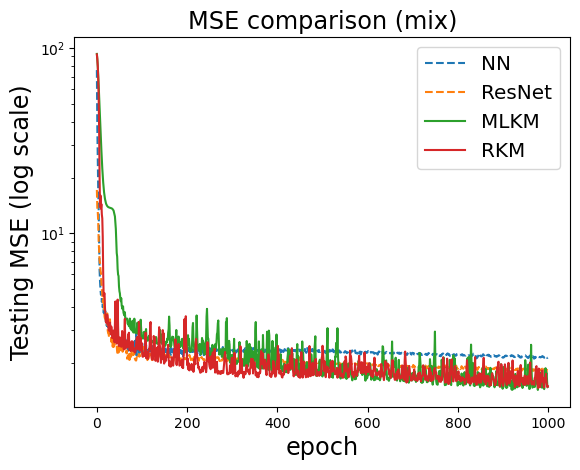

In [24]:
plt.plot(dnn_testloss,linestyle="--")
plt.plot(res_testloss,linestyle="--")
plt.plot(kernelnn_testloss)
plt.plot(reskernel_testloss)
plt.legend(["NN","ResNet","MLKM","RKM"],fontsize="x-large")
plt.xlabel("epoch",fontsize="xx-large")
plt.ylabel("Testing MSE (log scale)",fontsize="xx-large")
plt.yscale("log")
plt.title("MSE comparison (mix)",fontsize="xx-large")
plt.show()

In [25]:
print("Test: ",dnn_testloss[-1],res_testloss[-1],kernelnn_testloss[-1],reskernel_testloss[-1])

Test:  2.1400470698100973 1.8274743264218518 1.48668317293057 1.5004073887419214
